Generic imports

In [147]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
import matplotlib.image as img
import matplotlib as mpl

Create DF from dataset using images in folder

In [148]:
DATASET_TRAIN_PATH = './DataSet/sample/'

def create_df_from_images(ds_path=DATASET_TRAIN_PATH):
    
    files = os.scandir(ds_path)
    train = pd.DataFrame(columns=['file_name','image','nbfinger','hand'])

    for idx,file in enumerate(files):
        if not file.name.startswith('.') and file.is_file() and file.name.endswith('.png'):
            fname = file.name
            complete_fname = os.path.join(ds_path,fname)
            root,ext = os.path.splitext(fname)
            image = img.imread(complete_fname)
            train.loc[idx,'file_name'] = fname
            train.loc[idx,'image'] = image
            train.loc[idx,'nbfinger'] = root[-2:-1]
            train.loc[idx,'hand'] = root[-1:]
            
    train['nbfinger'] = train['nbfinger'].astype('category')
    train['hand'] = train['hand'].astype('category')
    return train

t1 = time.time()
train = create_df_from_images(DATASET_TRAIN_PATH)
t2 = time.time()
print('dataset created in %.2f seconds' %(t2 - t1))

dataset created in 0.21 seconds


Check repartition of images among categories - should be same for all

In [149]:
train['nbfinger'].value_counts()

4    21
1    18
5    17
2    17
3    14
0    13
Name: nbfinger, dtype: int64

In [150]:
train['hand'].value_counts()

L    52
R    48
Name: hand, dtype: int64

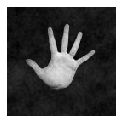

In [151]:
def plot_image(image):
    plt.imshow(image, cmap = mpl.cm.gray, interpolation="nearest")
    plt.axis("off")

image = train.loc[3,'image']
plt.figure(figsize=(2,2))
plot_image(image)

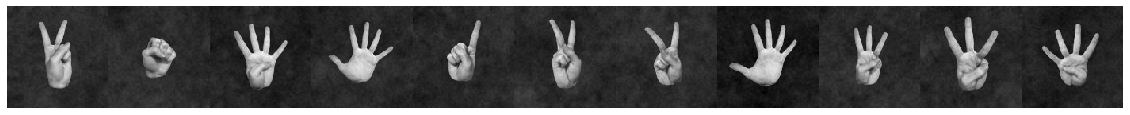

In [152]:
def plot_images(images):
    conc_images = np.concatenate(images,axis=1)
    plt.imshow(conc_images, cmap = mpl.cm.gray, interpolation="nearest")
    plt.axis("off")
    
image = train.loc[:10,'image']
plt.figure(figsize=(20,20))
plot_images(image)

# make the function more versatile --> display a square of images
# in this case 10 pictures - use a 4x4 display (fill the missing image by empty 128x128 array)